In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan  20 13:29:40 2022

@author: sgboakes
"""

import numpy as np
import matplotlib.pyplot as plt
from pysatellite import Transformations, Functions, Filters
import pysatellite.config as cfg

if __name__ == "__main__":

    plt.close('all')
    # ~~~~ Variables

    sin = np.sin
    cos = np.cos
    pi = np.float64(np.pi)

    sensLat = np.float64(28.300697)
    sensLon = np.float64(-16.509675)
    sensAlt = np.float64(2390)
    sensLLA = np.array([[sensLat * pi / 180], [sensLon * pi / 180], [sensAlt]], dtype='float64')
    # sensLLA = np.array([[pi/2], [0], [1000]], dtype='float64')
    sensECEF = Transformations.LLAtoECEF(sensLLA)
    sensECEF.shape = (3, 1)

    simLength = cfg.simLength
    stepLength = cfg.stepLength

    mu = cfg.mu

    trans_earth = True

    # ~~~~ Satellite Conversion

    # Define sat pos in ECI and convert to AER
    # radArr: radii for each sat metres
    # omegaArr: orbital rate for each sat rad/s
    # thetaArr: inclination angle for each sat rad
    # kArr: normal vector for each sat metres

    radArr = np.array([7e6, 7e6, 7e6, 7e6], dtype='float64')

    omegaArr = 1 / np.sqrt(radArr ** 3 / mu)

    thetaArr = np.array([[0.0], [0.1], [0.2], [0.3]], dtype='float64')

    kArr = np.array([[0, 0, 0],
                     [0, 0, 1],
                     [1 / np.sqrt(2), 1 / np.sqrt(2), 0],
                     [1 / np.sqrt(3), 1 / np.sqrt(3), 1 / np.sqrt(3)]],
                    dtype='float64')

    num_sats = len(radArr)

    # Make data structures
    satECI = {chr(i + 97): np.zeros((3, simLength)) for i in range(num_sats)}
    satAER = {chr(i + 97): np.zeros((3, simLength)) for i in range(num_sats)}

    for i in range(num_sats):
        c = chr(i + 97)
        for j in range(simLength):
            v = np.array([[radArr[i] * sin(omegaArr[i] * (j + 1) * stepLength)],
                          [0],
                          [radArr[i] * cos(omegaArr[i] * (j + 1) * stepLength)]], dtype='float64')

            satECI[c][:, j] = (v @ cos(thetaArr[i])) + (np.cross(kArr[i, :].T, v.T) * sin(thetaArr[i])) + (
                        kArr[i, :].T * np.dot(kArr[i, :].T, v) * (1 - cos(thetaArr[i])))

            satAER[c][:, j:j + 1] = Transformations.ECItoAER(satECI[c][:, j], stepLength, j + 1, sensECEF, sensLLA[0],
                                                             sensLLA[1])

            if not trans_earth:
                if satAER[c][1, j] < 0:
                    satAER[c][:, j:j + 1] = np.array([[np.nan], [np.nan], [np.nan]])

        if np.isnan(satAER[c]).all():
            print('Satellite {s} is not observable'.format(s=c))

    # Add small deviations for measurements
    # Using calculated max measurement deviations for LT:
    # Based on 0.15"/pixel, sat size = 2m, max range = 1.38e7
    # sigma = 1/2 * 0.15" for it to be definitely on that pixel
    # Add angle devs to Az/Elev, and range devs to Range

    angMeasDev, rangeMeasDev = 1e-6, 20

    satAERMes = {chr(i + 97): np.zeros((3, simLength)) for i in range(num_sats)}
    for i in range(num_sats):
        c = chr(i + 97)
        satAERMes[c][0, :] = satAER[c][0, :] + (angMeasDev * np.random.randn(1, simLength))
        satAERMes[c][1, :] = satAER[c][1, :] + (angMeasDev * np.random.randn(1, simLength))
        satAERMes[c][2, :] = satAER[c][2, :] + (rangeMeasDev * np.random.randn(1, simLength))

    satECIMes = {chr(i + 97): np.zeros((3, simLength)) for i in range(num_sats)}
    for i in range(num_sats):
        c = chr(i + 97)
        for j in range(simLength):
            satECIMes[c][:, j:j + 1] = Transformations.AERtoECI(satAERMes[c][:, j], stepLength, j+1, sensECEF,
                                                                sensLLA[0], sensLLA[1])

    satState = {chr(i + 97): np.zeros((6, 1)) for i in range(num_sats)}
    for i in range(num_sats):
        c = chr(i + 97)
        for j in range(simLength):
            if np.all(np.isnan(satECIMes[c][:, j])):
                continue
            else:
                satState[c][0:3] = np.reshape(satECIMes[c][:, j], (3, 1))
                break

    # Process noise
    stdAng = np.float64(1e-5)
    coefA = np.float64(0.25 * stepLength ** 4.0 * stdAng ** 2.0)
    coefB = np.float64(stepLength ** 2.0 * stdAng ** 2.0)
    coefC = np.float64(0.5 * stepLength ** 3.0 * stdAng ** 2.0)

    procNoise = np.array([[coefA, 0, 0, coefC, 0, 0],
                          [0, coefA, 0, 0, coefC, 0],
                          [0, 0, coefA, 0, 0, coefC],
                          [coefC, 0, 0, coefB, 0, 0],
                          [0, coefC, 0, 0, coefB, 0],
                          [0, 0, coefC, 0, 0, coefB]],
                         dtype='float64')

    covState = {chr(i + 97): np.zeros((6, 6)) for i in range(num_sats)}
    for i in range(num_sats):
        c = chr(i + 97)
        covState[c] = np.float64(1e10) * np.identity(6)

    covAER = np.array([[(angMeasDev * 180 / pi) ** 2, 0, 0],
                       [0, (angMeasDev * 180 / pi) ** 2, 0],
                       [0, 0, rangeMeasDev ** 2]],
                      dtype='float64'
                      )

    measureMatrix = np.append(np.identity(3), np.zeros((3, 3)), axis=1)

    
    # ~~~~~~ CHECK
    totalStates = {chr(i + 97): np.zeros((6, simLength)) for i in range(num_sats)}
    diffState = {chr(i + 97): np.zeros((3, simLength)) for i in range(num_sats)}
    err_X_ECI = {chr(i + 97): np.zeros(simLength) for i in range(num_sats)}
    err_Y_ECI = {chr(i + 97): np.zeros(simLength) for i in range(num_sats)}
    err_Z_ECI = {chr(i + 97): np.zeros(simLength) for i in range(num_sats)}

    # ~~~~~ Using EKF

    delta = 1e-6
    for i in range(num_sats):
        c = chr(i + 97)
        mesCheck = False
        for j in range(simLength):
            while not mesCheck:
                if np.all(np.isnan(satECIMes[c][:, j])):
                    break
                else:
                    mesCheck = True
                    break

            if not mesCheck:
                continue

            func_params = {
                "stepLength": stepLength,
                "count": j + 1,
                "sensECEF": sensECEF,
                "sensLLA[0]": sensLLA[0],
                "sensLLA[1]": sensLLA[1]
            }

            jacobian = Functions.jacobian_finder("AERtoECI", np.reshape(satAERMes[c][:, j], (3, 1)), func_params, delta)

            # covECI = np.matmul(np.matmul(jacobian, covAER), jacobian.T)
            covECI = jacobian @ covAER @ jacobian.T

            stateTransMatrix = Functions.jacobian_finder("kepler", satState[c], [], delta)

            satState[c], covState[c] = Filters.EKF_ECI(satState[c], covState[c], satECIMes[c][:, j], stateTransMatrix,
                                                       measureMatrix, covECI, procNoise)

            totalStates[c][:, j] = np.reshape(satState[c], 6)
            err_X_ECI[c][j] = (np.sqrt(np.abs(covState[c][0, 0])))
            err_Y_ECI[c][j] = (np.sqrt(np.abs(covState[c][1, 1])))
            err_Z_ECI[c][j] = (np.sqrt(np.abs(covState[c][2, 2])))
            diffState[c][:, j] = totalStates[c][0:3, j] - satECI[c][:, j]
            # print(satState[c])


In [2]:
from __future__ import absolute_import, division, print_function

import base64
# import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# import PIL.Image
# import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

2022-01-21 15:02:56.018057: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-21 15:02:56.018092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
from numpy import int32, float32

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts


class PyEnvironment(object):

    def reset(self):
        """Return initial_time_step."""
        self._current_time_step = self._reset()
        return self._current_time_step

    def step(self, action):
        """Apply action and return new time_step."""
        if self._current_time_step is None:
            return self.reset()
        self._current_time_step = self._step(action)
        return self._current_time_step

    def current_time_step(self):
        return self._current_time_step

    def time_step_spec(self):
        """Return time_step_spec."""

    @abc.abstractmethod
    def observation_spec(self):
        """Return observation_spec."""

    @abc.abstractmethod
    def action_spec(self):
        """Return action_spec."""

    @abc.abstractmethod
    def _reset(self):
        """Return initial_time_step."""

    @abc.abstractmethod
    def _step(self, action):
        """Apply action and return new time_step."""

        
class SatEnv(py_environment.PyEnvironment):

    def __init__(self):
        self._num_look_spots = num_sats
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=self._num_look_spots, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(4,), dtype=np.float32, minimum=0, name='observation')
        self._state = 0
        self._episode_ended = False
        self._episode_duration = 0
        self._max_episode_length = simLength

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        # self._state = 0
        self._episode_ended = False
        self._episode_duration = 0
        #import pdb; pdb.set_trace()
        return ts.restart(np.array([0.,0.,0.,0.], dtype=np.float32))

    def _step(self, action):

        reward = 0
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()

        
        
#         print('simlength {s} current ep {e}'.format(s=simLength,e=self._episode_duration))
        # Radial error
        error = [None] * num_sats
        for i in range(num_sats):
            c = chr(i + 97)
            error[i] = np.sqrt(err_X_ECI[c][self._episode_duration]**2 +
                             err_Y_ECI[c][self._episode_duration]**2 +
                             err_Z_ECI[c][self._episode_duration]**2)
            

        # Make sure episodes don't go on forever.
        if action == error.index(max(error)):
            reward = 1

        self._state = (self._state + 1) % self._num_look_spots
        # self._state = dif
        
        # print(self._state)
        # print("reward = ", reward)

        self._episode_duration += 1
        error = np.array(error, dtype=np.float32)

        if self._episode_duration >= self._max_episode_length:
            print('here')
            #import pdb; pdb.set_trace() # ALWAYS ON SAME LINE
            self._episode_ended = True
            return ts.termination(error, reward)
        else:
            return ts.transition(error, reward=reward, discount=1.0)


env = SatEnv()
utils.validate_py_environment(env, episodes=5)

tf_env = tf_py_environment.TFPyEnvironment(env)
time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    episode_reward = 0
    episode_steps = 0
    while not time_step.is_last():
        action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
        time_step = tf_env.step(action)
        episode_steps += 1
        episode_reward += time_step.reward.numpy()
    rewards.append(episode_reward)
    steps.append(episode_steps)
    time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)

env.reset()

here
here
here
here
here
here
here
here
here
here
num_episodes: 5 num_steps: 2500
avg_length 500.0 avg_reward: 95.2


TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0., 0., 0., 0.], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [24]:
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [25]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [27]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [28]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

compute_avg_return(eval_env, random_policy, num_eval_episodes)

here
here
here
here
here
here
here
here
here
here


99.8

In [29]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmpcm5g7ki8.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmpcm5g7ki8
[reverb/cc/platform/default/server.cc:71] Started replay server on port 21787


In [30]:
agent.collect_data_spec
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [31]:
#@test {"skip": true}
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([89.52537, 93.8907 , 83.69445, 90.26161], dtype=float32),
  'reward': array(0., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [32]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

iterator = iter(dataset)
print(iterator)

In [33]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

#   if step % log_interval == 0:
#     print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

here
here
here
here
here
here
here
here
here
here
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:163] Sampler and server are owned by the same process (30020) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (30020) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (30020) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (30020) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (30020) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (30020) so Table uniform_table is accessed directly without gRPC.


here
here
here
here
here
here
here
here
here
here
here
here
step = 1000: Average Return = 48.0
here
here
here
here
here
here
here
here
here
here
here
here
step = 2000: Average Return = 93.0
here
here
here
here
here
here
here
here
here
here
here
here
step = 3000: Average Return = 9.0
here
here
here
here
here
here
here
here
here
here
here
here
step = 4000: Average Return = 14.0
here
here
here
here
here
here
here
here
here
here
here
here
step = 5000: Average Return = 0.0
here
here
here
here
here
here
here
here
here
here
here
here
step = 6000: Average Return = 88.0
here
here
here
here
here
here
here
here
here
here
here
here
step = 7000: Average Return = 121.0
here
here
here
here
here
here
here
here
here
here
here
here
step = 8000: Average Return = 131.0
here
here
here
here
here
here
here
here
here
here
here
here
step = 9000: Average Return = 63.0
here
here
here
here
here
here
here
here
here
here
here
here
step = 10000: Average Return = 9.0
here
here
here
here
here
here
here
here
here
here


Text(0.5, 0, 'Iterations')

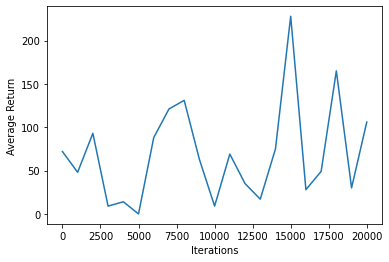

In [34]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
# plt.ylim(top=250)